In [1]:
import sys

package_paths = [
    '../input/rangerdeeplearningoptimizermaster/Ranger-Deep-Learning-Optimizer-master',
    '../input/pytorchoptimizermaster/pytorch-optimizer-master',
    '../input/pytorchimagemodelsmaster/pytorch-image-models-master',
]

for pth in package_paths:
    sys.path.append(pth)

In [2]:
# lib
import os
import gc
import random
import math
import time
import pickle

import albumentations as A
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from albumentations.pytorch.transforms import ToTensorV2
from glob import glob
from scipy import stats
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_optimizer
import timm
from torch.utils.data import DataLoader, Dataset
from torch.optim.optimizer import Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar

if not os.path.exists('models'):
    os.mkdir('models')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 777
seed_everything(SEED)

torch.__version__, timm.__version__

('1.7.0', '0.4.4')

In [3]:
#data_path = '../input/ranzcr-clip-catheter-line-classification/'
#data_path = '../input/debug/'
#data_path = '../input/train_512/'
#data_path = '../input/train_gray_512/'
data_path = '../input/train-gray-512/train_gray_512/'
#data_path = '../input/train_786/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger()
logger.info(f'Set seed: {SEED}')

Set seed: 777


# CFG

In [5]:
class CFG:
    device = device
    debug = False
    
    # fold
    n_fold = 5
    
    # data set 
    size = 384
    in_chans = 1
    bs = 128
    pre_load = False
    cat_nums = None
    worker = 4
    max_prefetch = 16

    # model
    epochs = 25
    model_name = 'nf_resnet50'
    hidden_size = 256
    dropout = 0.5
    
    # gradient
    iters_to_accumulate = 1
    max_grad_norm = 5.0
    criterion = None
    metric = None
    smooth = 0.005
    
    # optimizer
    lr = 1e-3
    wd = 1e-6
    patience = 5
    optimizer = torch.optim.Adam
    optim_param = {'lr': lr, 'weight_decay': wd}
    scheduler = torch.optim.lr_scheduler.LambdaLR
    scheduler_param = {'lr_lambda': lambda epoch: 1}
    
    
if CFG.debug: data_path = '../input/debug/'
if os.name == 'nt': CFG.worker = 0

# load

In [6]:
train_df = pd.read_csv(data_path + 'train.csv')
#train_df = train_df.head(1000)
#CFG.cat_nums = train_df.label.nunique()

target_cols = [
    'ETT - Abnormal', 
    'ETT - Borderline', 
    'ETT - Normal', 
    'NGT - Abnormal',
    'NGT - Borderline', 
    'NGT - Incompletely Imaged', 
    'NGT - Normal',
    'CVC - Abnormal', 
    'CVC - Borderline', 
    'CVC - Normal',
    'Swan Ganz Catheter Present'
]

CFG.target_cols = target_cols
CFG.cat_nums = len(CFG.target_cols)
CFG.features_col = 'StudyInstanceUID'

# folds

In [7]:
fold_idxes = {}
cv = GroupKFold(n_splits=CFG.n_fold)
groups = train_df['PatientID'].values

for n, fold_idx in enumerate(cv.split(train_df, 
                                                train_df[CFG.target_cols], 
                                                groups)):
    trn_idx, val_idx = fold_idx
    train_df.loc[val_idx, 'fold'] = int(n)
    fold_idxes[n] = fold_idx
    
with open("fold_idxes.pkl", "wb") as f:
    pickle.dump(fold_idxes, f)
train_df.fold = train_df.fold.astype(int)
train_df.groupby('fold').size()

fold
0    6017
1    6017
2    6017
3    6016
4    6016
dtype: int64

# dataset

In [8]:
aug = A.Compose([
    #A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5,
                       shift_limit=0.0625,
                       scale_limit=0.2,
                       rotate_limit=20),
    A.RandomGamma(),
    A.RandomContrast(p=0.5),
    A.CoarseDropout(p=0.2),
])


def get_transforms(aug=None, size=CFG.size):
    resize = A.OneOf(
        [
            #A.Resize(size, size, p=0.1),
            #A.RandomCrop(size, size, p=0.9),
            A.RandomResizedCrop(size, size, scale=(0.8, 1.0)),
        ],
        p=1.0) if aug else A.Resize(size, size)

    return A.Compose(
        [
            resize,
            aug,
            A.Normalize(
                #mean=[0.485, 0.456, 0.406],
                #std=[0.229, 0.224, 0.225],
                mean=[0.485, ],
                std=[0.229, ],
            ),
            ToTensorV2(),
        ],
        p=1.0,
    )


class TrainDataset_Preload(Dataset):
    def __init__(
            self,
            xs=None,
            ys=None,
            transform=None,
    ):
        self.xs = xs
        #self.ys = torch.LongTensor(ys)
        self.ys = torch.FloatTensor(ys)
        self.transform = get_transforms(transform)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        x = self.xs[idx]
        x = self.transform(image=x)['image']
        y = self.ys[idx]
        return x, y
    
    
class TrainDataset(Dataset):
    def __init__(
            self,
            df=None,
            features_col=None,
            labels_col=None,
            data_path=None,
            transform=None,
    ):
        self.image_path = data_path + 'train/'
        self.image_id = df[features_col].values
        #self.labels = torch.LongTensor(df[labels_col].values)
        self.labels = torch.FloatTensor(df[labels_col].values)
        self.transform = get_transforms(transform)

    def __len__(self):
        return len(self.image_id)

    def __getitem__(self, idx):
        # read image
        x = cv2.imread(self.image_path + self.image_id[idx] + '.jpg', 2)
        x = self.transform(image=x)['image']
        y = self.labels[idx]
        return x, y


# debug
if 0:
    # normal
    trn_ds = TrainDataset(train_df,
                          CFG.features_col,
                          CFG.target_cols,
                          data_path,
                          transform=aug)
    trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True, drop_last=True)
    for x, y in trn_dl:
        break
    print(x.shape, y.shape)
    
    # preload
    idx = np.random.randint(0, len(train_df), size=100)
    sub_df = train_df.iloc[idx].copy()
    
    xs = []
    for uid in sub_df.StudyInstanceUID: 
        xs.append(cv2.imread(f'{data_path}train/{uid}.jpg'))
    xs = np.array(xs)
    ys = sub_df[CFG.target_cols].values

    trn_ds = TrainDataset_Preload(xs=xs, 
                                  ys=ys,
                                  transform=aug)
    trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True, drop_last=True)
    for x, y in trn_dl:
        break
    print(x.shape, y.shape)    

# model 

In [9]:
def compute_metric(preds, ys):   
    preds = preds.sigmoid() > 0.5
    return (preds == ys).float().mean()

def compute_metric2(preds, ys):
    return np.mean([roc_auc_score(ys[:, i], preds[:, i]) for i in range(11)])

CFG.metric = compute_metric
CFG.metric2 = compute_metric2
CFG.criterion = nn.BCEWithLogitsLoss()



class Model(nn.Module):
    def __init__(self,
                 model_name='tf_efficientnet_b0_ns',
                 n_class=5,
                 in_chans=3,
                 pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, 
                                       num_classes=n_class, 
                                       in_chans=in_chans, 
                                       pretrained=pretrained)
        
    def forward(self, x):
        return self.model(x)

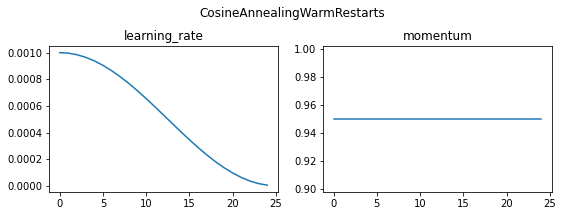

In [10]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = torch_optimizer.Ranger
CFG.optim_param = optim_param

scheduler_param = {
    'T_0': CFG.epochs,
    'T_mult': 1,
    'eta_min': 1e-6,
}
CFG.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts
CFG.scheduler_param = scheduler_param


cfg = CFG
model = nn.Linear(1, 1)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if type(scheduler).__name__ == 'OneCycleLR':
        step = cfg.epochs* (len(os.listdir(data_path+'train_images/')) // CFG.bs)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(type(scheduler).__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)
    plt.subplots_adjust(top=0.80)
    plt.show()


show_learning_rate_scheduler()

# learn

In [11]:
import threading
import queue


class MultiThreadWrapper(threading.Thread):
    def __init__(self, generator, max_prefetch=1):
        """
        This function transforms generator into a background-thead generator.
        :param generator: generator or genexp or any
        It can be used with any minibatch generator.
        It is quite lightweight, but not entirely weightless.
        Using global variables inside generator is not recommended (may rise GIL and zero-out the benefit of having a background thread.)
        The ideal use case is when everything it requires is store inside it and everything it outputs is passed through queue.
        There's no restriction on doing weird stuff, reading/writing files, retrieving URLs [or whatever] wlilst iterating.
        :param max_prefetch: defines, how many iterations (at most) can background generator keep stored at any moment of time.
        Whenever there's already max_prefetch batches stored in queue, the background process will halt until one of these batches is dequeued.
        !Default max_prefetch=1 is okay unless you deal with some weird file IO in your generator!
        Setting max_prefetch to -1 lets it store as many batches as it can, which will work slightly (if any) faster, but will require storing
        all batches in memory. If you use infinite generator with max_prefetch=-1, it will exceed the RAM size unless dequeued quickly enough.
        """
        threading.Thread.__init__(self)
        self.queue = queue.Queue(max_prefetch)
        self.generator = generator
        self.daemon = True
        self.start()
        self.exhausted = False

    def run(self):
        for item in self.generator:
            self.queue.put(item)
        self.queue.put(None)

    def __len__(self):
        return len(self.generator)

    def __next__(self):
        if self.exhausted:
            raise StopIteration
        else:
            next_item = self.queue.get()
            if next_item is None:
                raise StopIteration
            return next_item

    def __iter__(self):
        return self
    
    
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.
        self.avg = 0.
        self.sum = 0.
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



class EearlyStop:
    def __init__(self, patience=4, min_delta=0.005, mode='min'):
        '''
        mode: {min, max}
        '''
        self.record = np.inf if mode == 'min' else -np.inf
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.wait = 0
        
    def cal_improve(self, val_loss: float) -> bool:
        esp = 1e-8
        ratio = (val_loss - self.record + esp) / (self.record + esp)
        if ratio > 0:
            improve = False
        else:
            improve = True if -ratio > self.min_delta else False
        return improve
    
    def stop(self, val_loss: float) -> bool:
        # improve = self.cal_improve(val_loss)
        improve = True if val_loss < self.record else False
        if self.mode == 'max': improve = not improve
        
        if improve: 
            self.wait = 0
            self.record = val_loss            
        else: self.wait += 1

        
        if self.wait > self.patience: return True
        else: return False

In [12]:
class Learner:
    def __init__(self, cfg, model):
        self.cfg = cfg

        self.criterion = cfg.criterion
        self.metric = cfg.metric
        self.scaler = torch.cuda.amp.GradScaler()

        # recorder
        self.best_loss = np.inf
        self.best_score = 0
        self.epoch = 0
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.mb = master_bar(range(1, cfg.epochs + 1))
        self.mb.write(('epoch', 'train loss', 'train metric', 'val loss',
                       'val metric', 'time'),
                      table=True)
        self.early_stop = EearlyStop(patience=CFG.patience, min_delta=0.05, mode='max')

        # model
        self.device = cfg.device
        self.model = model.to(cfg.device)
        self.optimizer = cfg.optimizer(self.model.parameters(), **cfg.optim_param)
        self.scheduler = cfg.scheduler(self.optimizer, **cfg.scheduler_param)

    def trn_fn(self, trn_loader):
        self.model.train()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        
        #if cfg.worker == 0 and os.name == 'nt':
        trn_loader = MultiThreadWrapper(trn_loader, cfg.max_prefetch)        
        
        trn_tqdm = progress_bar(trn_loader,
                                total=int(len(trn_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(trn_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            # forward, backward
            with torch.cuda.amp.autocast():
                preds = self.model(xs)
                loss = self.criterion(preds, ys).mean()
                loss_item = loss.item()
                running_loss.update(loss_item, batch_size)
            
            # backward
            loss = loss / self.cfg.iters_to_accumulate
            self.scaler.scale(loss).backward()
            
            # gradient accumulate
            if (i + 1) % self.cfg.iters_to_accumulate == 0:
                # clip grad
                self.scaler.unscale_(self.optimizer)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                                                self.cfg.max_grad_norm)
                # step
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()
            
            # step scheduler if lr scheduler is onecycle
            if type(self.scheduler).__name__ == 'OneCycleLR':
                self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
                self.scheduler.step()
                
            # metric
            metric = self.metric(preds, ys)
            running_metric.update(metric, batch_size)
            
            # set commet on child progressbar
            self.mb.child.comment = (f'loss={loss_item:.4f}, '
                                     f'metric={metric:.4f}')

        # step scheduler if lr scheduler is not onecycle
        if type(self.scheduler).__name__ != 'OneCycleLR':
            self.history['lrs'].append(self.scheduler.optimizer.param_groups[0]['lr'])
            self.scheduler.step()
        return running_loss.avg, running_metric.avg

    def val_fn(self, val_loader):
        self.model.eval()
        running_loss = AverageMeter()
        running_metric = AverageMeter()
        val_preds = []
        
        #if cfg.worker == 0 and os.name == 'nt':
        val_loader = MultiThreadWrapper(val_loader, cfg.max_prefetch//4)

        val_tqdm = progress_bar(val_loader,
                                total=int(len(val_loader)),
                                parent=self.mb)
        for i, (xs, ys) in enumerate(val_tqdm):
            batch_size = len(xs)
            xs = xs.to(self.device)
            ys = ys.to(self.device)

            self.model.eval()
            with torch.cuda.amp.autocast():
                with torch.no_grad():
                    preds = self.model(xs)
                    loss = self.criterion(preds, ys).mean()
                    metric = self.metric(preds, ys)
                    
            # record
            running_loss.update(loss.item(), batch_size)
            running_metric.update(metric, batch_size)
            val_preds.append(preds.detach().cpu().numpy())

            # set commet on child progressbar
            self.mb.child.comment = (f'val_loss={loss.item():.4f}, '
                                     f'val_metric={metric:.4f}')

        val_preds = np.concatenate(val_preds)
        return running_loss.avg, running_metric.avg, val_preds

    def plot_history(self, fold_num=0):
        fig = plt.figure(figsize=(16, 3))
        fig.subplots_adjust(top=0.8)
        plt.suptitle(f'fold{fold_num}')

        # metrics
        plt.subplot(131)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_metrics'], 'C0', label='train')
        plt.plot(self.history['val_metrics'], 'C1', label='val')
        plt.title(f'Metric')
        plt.legend()
        plt.ylabel("Metric")
        plt.xlabel("Epoch")

        # loss
        plt.subplot(132)
        #plt.ylim(0.01, 0.03)
        plt.plot(self.history['trn_losses'], 'C0', label='train')
        plt.plot(self.history['val_losses'], 'C1', label='val')
        plt.title(f'Loss')
        plt.legend()
        plt.ylabel("Loss")
        plt.xlabel("Epoch")

        # lr
        plt.subplot(133)
        plt.plot(self.history['lrs'][1:], 'C0', label='lr')
        plt.title(f'Learning rate')
        plt.ylabel("lr")
        if self.history['lrs'][0] == 'OneCycleLR':
            plt.xlabel("Iteration")
        else:
            plt.xlabel("Epoch")

        plt.show()

    def fit_single(
        self,
        fold_idx,
        trn_loader,
        val_loader,
        fold_num=0,
    ):
        # recorder
        self.history = {
            'losses': [],
            'trn_losses': [],
            'trn_metrics': [],
            'val_losses': [],
            'val_metrics': [],
            'lrs': [],
        }
        self.history['lrs'].append(self.scheduler.__class__.__name__)
        trn_idx, val_idx = fold_idx

        # train & validate
        for epoch in self.mb:            
            self.epoch = epoch
            start_time = time.time()
            trn_loss, trn_metric = self.trn_fn(trn_loader)
            val_loss, val_metric, val_preds = self.val_fn(val_loader)

            # checkpoint
            #if val_loss < self.best_loss:
            if val_metric > self.best_score:
                logger.info(f'epoch{epoch} save best model... {val_metric}')
                #self.best_loss = val_loss
                self.best_score = val_metric
                
                save_name = f"fold_{fold_num}"
                np.save(save_name + 'preds', val_preds)
                self.save(save_name + '.pth')
                
            # calculate time
            end_time = time.time()
            m, s = divmod(end_time - start_time, 60)

            # record
            self.history['trn_losses'].append(trn_loss)
            self.history['trn_metrics'].append(trn_metric)
            self.history['val_losses'].append(val_loss)
            self.history['val_metrics'].append(val_metric)
            self.mb.write(
                (f'{epoch}', 
                 f'{trn_loss:.6f}', 
                 f'{trn_metric:.6f}',
                 f'{val_loss:.6f}', 
                 f'{val_metric:.6f}', 
                 f'{m:.0f}:{s:.0f}'),
                table=True)
            
            # early stop
            break_flag = self.early_stop.stop(val_metric)
            if break_flag:
                logger.info(f"early stop...")
                break
                
        # record cv score
        self.plot_history(fold_num)

        # del
        torch.cuda.empty_cache()
    
    def save(self, path):
        self.model.eval()
        torch.save({
            #'model_state_dict': self.model.model.state_dict(),
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'scaler': self.scaler.state_dict(),
            'best_loss': self.best_loss,
            'epoch': self.epoch,
            'history': self.history,   
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler'])
        self.best_loss = checkpoint['best_loss']
        self.epoch = checkpoint['epoch']
        self.history = checkpoint['history']

In [13]:
def sigmoid(x): return 1 / np.exp(-x)

def run_kfold(cfg, train_df, n_fold=5, aug=None, pre_load=False):

    if pre_load:
        xs = []
        for uid in train_df.StudyInstanceUID:
            xs.append(cv2.imread(f'{data_path}train/{uid}.jpg', 2))
        xs = np.array(xs)
        ys = train_df[CFG.target_cols].values

    # oof
    oof_df = pd.DataFrame()

    for fold_num in range(n_fold):
        
        # fold index
        logger.info(f'fold {fold_num}')
        trn_idx = train_df[train_df['fold'] != fold_num].index
        val_idx = train_df[train_df['fold'] == fold_num].index
        fold_idx = trn_idx, val_idx
        
        # ds
        if pre_load:
            trn_ds = TrainDataset_Preload(xs=xs[trn_idx],
                                          ys=ys[trn_idx],
                                          transform=aug)
            val_ds = TrainDataset_Preload(xs=xs[val_idx],
                                          ys=ys[val_idx],
                                          transform=aug)
        else:
            trn_ds = TrainDataset(train_df.iloc[trn_idx],
                                  cfg.features_col,
                                  cfg.target_cols,
                                  data_path,
                                  transform=aug)
            val_ds = TrainDataset(train_df.iloc[val_idx],
                                  cfg.features_col,
                                  cfg.target_cols,
                                  data_path,
                                  transform=None)
        # dl
        trn_dl = DataLoader(
            trn_ds,
            batch_size=CFG.bs,
            shuffle=True,
            drop_last=False,
            num_workers=cfg.worker,
        )
        val_dl = DataLoader(
            val_ds,
            batch_size=CFG.bs,
            drop_last=False,
            num_workers=cfg.worker,
        )
        
        # learner
        model = Model(model_name=cfg.model_name,
                      in_chans=cfg.in_chans,
                      n_class=cfg.cat_nums,
                      pretrained=True,
                     )
        learner = Learner(cfg, model)
        learner.fit_single(fold_idx, trn_dl, val_dl, fold_num)

        # fold score
        val_preds = np.load(f"fold_{fold_num}preds.npy")
        score = cfg.metric2(val_preds,
                            train_df.loc[val_idx, cfg.target_cols].values)
        logger.info(f"fold{fold_num} score: {score}")
        oof_ = pd.DataFrame(val_preds, index=val_idx)
        oof_df = pd.concat([oof_df, oof_])
    
    index = oof_df.reset_index().sort_values('index').index
    oof_df.loc[index].reset_index(drop=True, inplace=True)
    preds = sigmoid(oof_df.values) > 0.5
    score = cfg.metric2(preds, train_df[cfg.target_cols].values)
    logger.info(f"CV score: {score}")

    return oof_df, learner

fold 0


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/nf_resnet50_ra2-9f236009.pth" to /root/.cache/torch/hub/checkpoints/nf_resnet50_ra2-9f236009.pth


epoch,train loss,train metric,val loss,val metric,time
1,0.285131,0.874316,0.232941,0.901295,6:44
2,0.215704,0.907852,0.220158,0.909423,6:41
3,0.203329,0.911724,0.227642,0.903335,6:40
4,0.190398,0.915282,0.215689,0.908366,6:40
5,0.178204,0.921598,0.196885,0.916207,6:42
6,0.168058,0.926399,0.207241,0.908320,6:40
7,0.164192,0.928209,0.174031,0.926829,6:42
8,0.155577,0.932345,0.201939,0.918549,6:39
9,0.161073,0.929123,0.169003,0.927131,6:41
10,0.150455,0.934853,0.177130,0.924230,6:40


../input/rangerdeeplearningoptimizermaster/Ranger-Deep-Learning-Optimizer-master/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


epoch1 save best model... 0.9012950658798218


epoch2 save best model... 0.9094234704971313


epoch5 save best model... 0.9162073135375977


epoch7 save best model... 0.9268287420272827


epoch9 save best model... 0.9271307587623596


epoch12 save best model... 0.9300769567489624


epoch13 save best model... 0.9301979541778564


epoch17 save best model... 0.9313309788703918


epoch18 save best model... 0.9326151609420776


early stop...


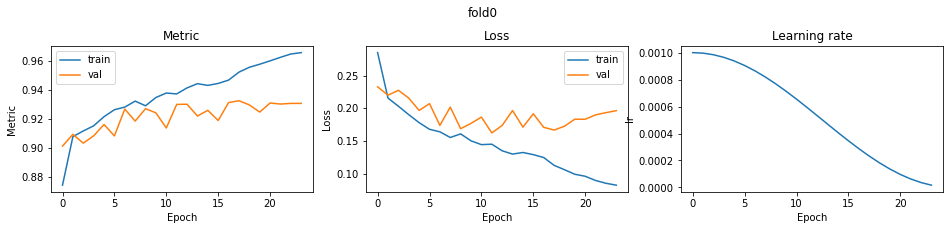

fold0 score: 0.9249398643619002


fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.273127,0.886864,0.270514,0.865986,6:41
2,0.212760,0.909306,0.214820,0.905359,6:41
3,0.197955,0.914640,0.217302,0.899285,6:40
4,0.185781,0.918036,0.211087,0.898772,6:40
5,0.182478,0.920348,0.246069,0.905011,6:40
6,0.175322,0.923536,0.190926,0.916283,6:41
7,0.164156,0.928507,0.187816,0.914500,6:40
8,0.163332,0.929414,0.178859,0.922326,6:42
9,0.154120,0.933509,0.175814,0.920936,6:40
10,0.150453,0.935311,0.176087,0.924728,6:41


epoch1 save best model... 0.8659856915473938


epoch2 save best model... 0.9053589701652527


epoch6 save best model... 0.916282594203949


epoch8 save best model... 0.9223261475563049


epoch10 save best model... 0.9247283935546875


epoch12 save best model... 0.9270853400230408


epoch13 save best model... 0.9271761178970337


epoch14 save best model... 0.9292005896568298


epoch17 save best model... 0.9294573664665222


epoch20 save best model... 0.9295179843902588


epoch22 save best model... 0.9296841025352478


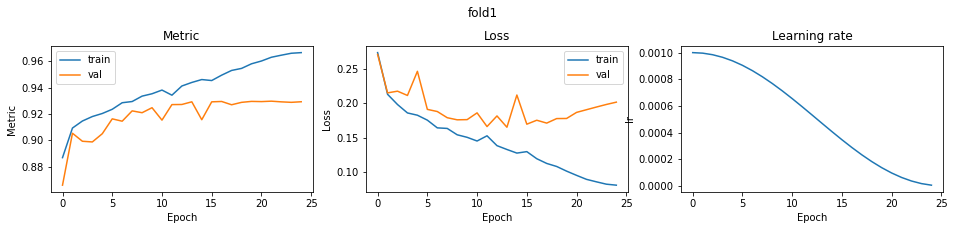

fold1 score: 0.9283344513943941


fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.279987,0.880004,0.221199,0.909257,6:41
2,0.215631,0.907357,0.296465,0.881503,6:40
3,0.213299,0.907879,0.237199,0.893015,6:41
4,0.195864,0.913624,0.310099,0.869536,6:40
5,0.191513,0.915089,0.187298,0.922372,6:40
6,0.175587,0.922527,0.201816,0.911040,6:40
7,0.167182,0.926717,0.185794,0.914152,6:40
8,0.162915,0.928235,0.177009,0.925575,6:41
9,0.156669,0.932152,0.163547,0.929337,6:42
10,0.155289,0.932152,0.170782,0.925650,6:41


epoch1 save best model... 0.9092570543289185


epoch5 save best model... 0.9223715662956238


epoch8 save best model... 0.9255747199058533


epoch9 save best model... 0.9293365478515625


epoch11 save best model... 0.9327360987663269


epoch13 save best model... 0.9342771172523499


epoch17 save best model... 0.9364978671073914


early stop...


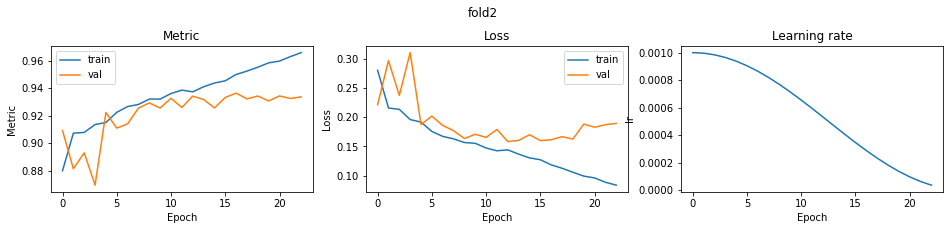

fold2 score: 0.919278068676347


fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.284663,0.879718,0.227719,0.902095,6:42
2,0.219200,0.906515,0.210202,0.910254,6:40
3,0.210725,0.908445,0.219763,0.892982,6:41
4,0.199810,0.912755,0.194122,0.912748,6:41
5,0.189485,0.917159,0.199825,0.901747,6:40
6,0.178535,0.920997,0.185497,0.918248,6:42
7,0.171226,0.925039,0.184618,0.914894,6:40
8,0.165872,0.927755,0.163106,0.929325,6:41


epoch1 save best model... 0.9020945429801941


epoch2 save best model... 0.9102544188499451


epoch4 save best model... 0.9127476811408997


epoch6 save best model... 0.9182484149932861


epoch8 save best model... 0.9293248057365417


In [14]:
if __name__ == '__main__':
    oof, learner = run_kfold(CFG, train_df, n_fold=CFG.n_fold, aug=aug, pre_load=CFG.pre_load)

In [ ]:
from IPython.display import FileLinks

FileLinks('.')